Payam Taebi
400104867

In [1]:
import copy
import torch.nn as nn


def replicate(block, N=6) -> nn.ModuleList:
    """
    Method to replicate the existing block to N set of blocks
    :param block: class inherited from nn.Module, mainly it is the encoder or decoder part of the architecture
    :param N: the number of stack, in the original paper they used 6
    :return: a set of N blocks
    """
    block_stack = nn.ModuleList([copy.deepcopy(block) for _ in range(N)])
    return block_stack

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split


In [3]:
data_path = '/kaggle/input/my-first-time-series/exchange_rate.txt'

with open(data_path, 'r') as file:
    lines = file.readlines()

# Split each line into individual exchange rates
data = [line.strip().split(',') for line in lines]

# Create a DataFrame
df = pd.DataFrame(data)

# Assign column names
column_names = ['Australia', 'British', 'Canada', 'Switzerland', 'China', 'Japan', 'New Zealand', 'Singapore']
df.columns = column_names

# Optionally, convert exchange rates to numeric values
df = df.astype(float)

# Print the first few rows of the DataFrame
print(df.head())

   Australia  British    Canada  Switzerland     China     Japan  New Zealand  \
0     0.7855   1.6110  0.861698     0.634196  0.211242  0.006838       0.5930   
1     0.7818   1.6100  0.861104     0.633513  0.211242  0.006863       0.5940   
2     0.7867   1.6293  0.861030     0.648508  0.211242  0.006975       0.5973   
3     0.7860   1.6370  0.862069     0.650618  0.211242  0.006953       0.5970   
4     0.7849   1.6530  0.861995     0.656254  0.211242  0.006940       0.5985   

   Singapore  
0   0.525486  
1   0.523972  
2   0.526316  
3   0.523834  
4   0.527426  


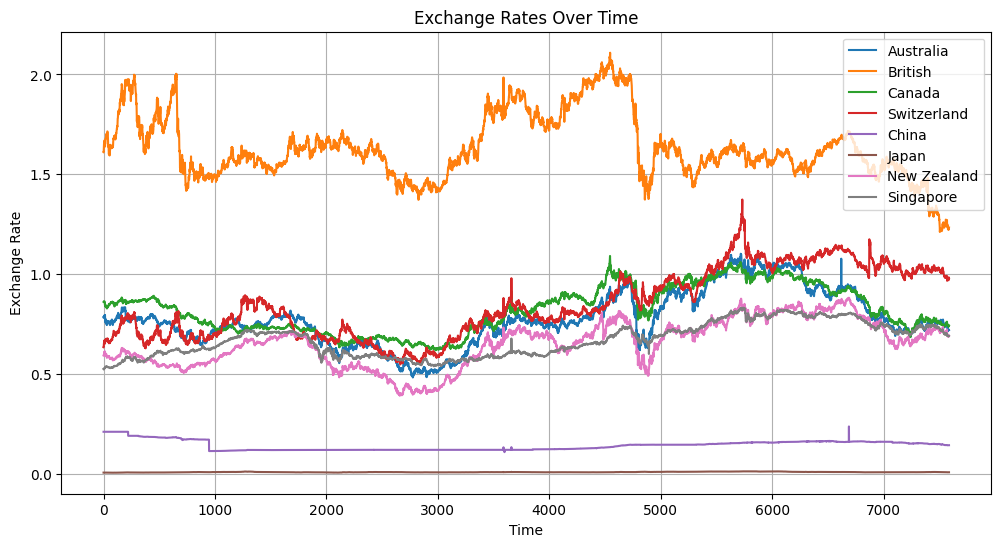

In [4]:
# Plotting the exchange rates over time
plt.figure(figsize=(12, 6))

# Plot each currency exchange rate
for currency in df.columns:
    plt.plot(df.index, df[currency], label=currency)

plt.title('Exchange Rates Over Time')
plt.xlabel('Time')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

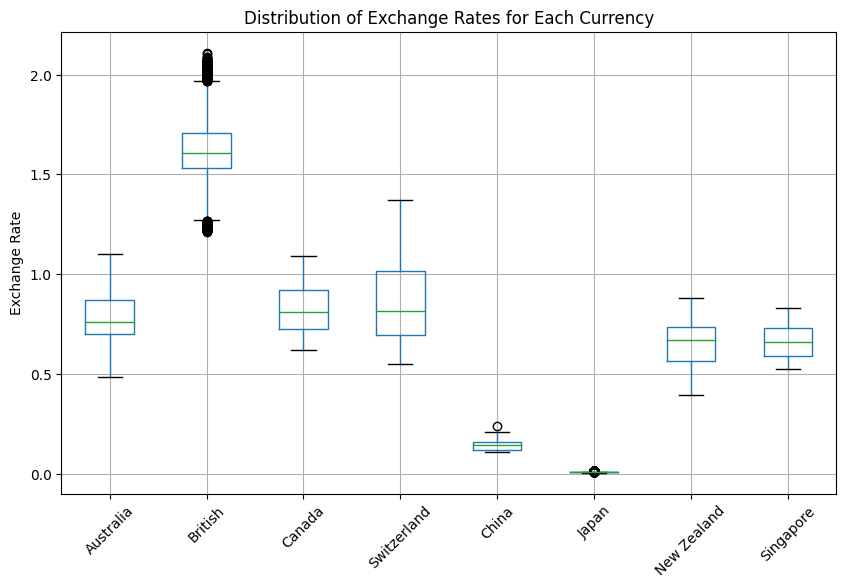

In [5]:
# Box plot of exchange rates for each currency
plt.figure(figsize=(10, 6))
df.boxplot()
plt.title('Distribution of Exchange Rates for Each Currency')
plt.ylabel('Exchange Rate')
plt.xticks(rotation=45)
plt.show()

In [6]:
# Get the size of the dataset
num_rows, num_columns = df.shape
print("Number of rows:", num_rows)
print("Number of columns:", num_columns)

Number of rows: 7588
Number of columns: 8


In [7]:
# Define custom dataset class
class ExchangeRateDataset(Dataset):
    def __init__(self, data, input_len, output_len):
        self.data = data
        self.input_len = input_len
        self.output_len = output_len

    def __len__(self):
        return len(self.data) - (self.input_len + self.output_len) + 1

    def __getitem__(self, idx):
        idx_end = idx + self.input_len
        input_seq = self.data[idx:idx_end]
        output_seq = self.data[idx_end:idx_end+self.output_len]
        return input_seq, output_seq

In [8]:
# Create DataLoader for train and test sets
input_dim = 10  # Lookback time series length
output_dim = 1  # Predicted length
batch_size = 64
data = df.values
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=False)

#print(train_data.shape) 6070 , 8

train_dataset = ExchangeRateDataset(train_data, input_dim, output_dim)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = ExchangeRateDataset(test_data, input_dim, output_dim)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

Using device: cuda


In [10]:
import torch
import torch.nn as nn
import math

class TransformerEmbedder(nn.Module):
    def __init__(self, c_in, model_dim, max_len=5000, dropout_rate=0.1):
        super(TransformerEmbedder, self).__init__()

        # Positional Encoding
        pos_encoding = self._generate_positional_encoding(max_len, model_dim)

        # Learnable Embedding
        self.conv1d = nn.Conv1d(in_channels=c_in, out_channels=model_dim, kernel_size=3, padding=1, padding_mode='circular', bias=False)
        nn.init.kaiming_normal_(self.conv1d.weight, mode='fan_in', nonlinearity='leaky_relu')

        self.dropout = nn.Dropout(dropout_rate)

        self.register_buffer('pos_encoding', pos_encoding.unsqueeze(0))

    def forward(self, x):
        # Learnable Embedding
        embedded = self.conv1d(x.permute(0, 2, 1)).transpose(1, 2)

        # Add Positional Encoding
        embedded += self.pos_encoding[:, :x.size(1)]

        # Apply dropout
        embedded = self.dropout(embedded)

        return embedded

    def _generate_positional_encoding(self, max_len, model_dim):
        encoding = torch.zeros(max_len, model_dim).float()
        pos = torch.arange(0, max_len).float().unsqueeze(1)
        freq = (torch.arange(0, model_dim, 2).float() * -(math.log(10000.0) / model_dim)).exp()
        encoding[:, 0::2] = torch.sin(pos * freq)
        encoding[:, 1::2] = torch.cos(pos * freq)
        return encoding

# Example Usage:
c_in = 3  # Input channels
model_dim = 64  # Dimension of the model
max_len = 1000  # Maximum sequence length
dropout_rate = 0.1  # Dropout rate

embedder = TransformerEmbedder(c_in, model_dim, max_len, dropout_rate)

# Assuming x is your input tensor
x = torch.randn(1, 10, c_in)  # Batch size x Sequence length x Input channels
output = embedder(x)
print(output.shape)  # Output shape: [batch_size, sequence_length, model_dim]


torch.Size([1, 10, 64])


In [11]:
import torch
import torch.nn as nn
from math import sqrt

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask=None):
        # Calculate attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / sqrt(q.size(-1))

        # Apply mask if provided
        if mask is not None:
            scores = scores.masked_fill(mask == 0, float('-inf'))

        # Apply softmax to get attention weights
        weights = self.softmax(scores)

        # Weighted sum of values
        output = torch.matmul(weights, v)

        return output, weights

class MultiHeadAttention(nn.Module):
    def __init__(self, model_dim, num_heads, max_seq_len=5000):
        super(MultiHeadAttention, self).__init__()
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads

        # Linear transformations for queries, keys, and values
        self.W_q = nn.Linear(model_dim, model_dim, bias=False)
        self.W_k = nn.Linear(model_dim, model_dim, bias=False)
        self.W_v = nn.Linear(model_dim, model_dim, bias=False)

        # Final linear transformation for output
        self.W_o = nn.Linear(model_dim, model_dim)

        # Scaled Dot-Product Attention module
        self.attention = ScaledDotProductAttention()

        # Register buffer for triangular mask
        self.register_buffer('tril_mask', torch.tril(torch.ones(max_seq_len, max_seq_len)))

    def forward(self, q, k, v, seq_len=10):
        # Linear transformations
        q = self.W_q(q).view(q.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.W_k(k).view(k.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.W_v(v).view(v.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled Dot-Product Attention
        output, weights = self.attention(q, k, v, mask=self.tril_mask[:seq_len, :seq_len])

        # Concatenate heads and perform final linear transformation
        output = output.transpose(1, 2).contiguous().view(output.size(0), -1, self.model_dim)
        output = self.W_o(output)

        return output

# Example Usage:
model_dim = 64  # Model dimension
num_heads = 8   # Number of attention heads
max_seq_len = 100  # Maximum sequence length
multi_head_attention = MultiHeadAttention(model_dim, num_heads, max_seq_len)

# Assuming q, k, and v are your input tensors
q = torch.randn(1, 10, model_dim)  # Batch size x Sequence length x Model dimension
k = torch.randn(1, 10, model_dim)  # Batch size x Sequence length x Model dimension
v = torch.randn(1, 10, model_dim)  # Batch size x Sequence length x Model dimension
seq_len = 10  # Length of the sequence
output = multi_head_attention(q, k, v, seq_len)
print(output.shape)  # Output shape: [batch_size, sequence_length, model_dim]


torch.Size([1, 10, 64])


In [12]:
import torch.nn as nn

class FFLayer(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super(FFLayer, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_dim)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x


In [13]:
#this layers from https://github.com/Khaliladib11/Transformer-from-scratch
class EncoderLayer(nn.Module):
    def __init__(self, model_dim, ffn_dim, num_heads, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(model_dim, num_heads)
        self.ffn = FFLayer(model_dim, ffn_dim)
        self.norm1 = nn.LayerNorm(model_dim)
        self.norm2 = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Multi-Head Self-Attention
        residual = x
        out = self.self_attention(x, x, x)
        out = self.dropout(out)
        out = self.norm1(out + residual)

        # Feed Forward Network
        residual = out
        out = self.ffn(out)
        out = self.dropout(out)
        out = self.norm2(out + residual)

        return out


class Encoder(nn.Module):
    def __init__(self, model_dim, ffn_dim, num_heads, num_layers, dropout_rate=0.1):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(model_dim, ffn_dim, num_heads, dropout_rate) for _ in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


class DecoderLayer(nn.Module):
    def __init__(self, model_dim, ffn_dim, num_heads, dropout_rate=0.1):
        super(DecoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(model_dim, num_heads)
        self.enc_dec_attention = MultiHeadAttention(model_dim, num_heads)
        self.ffn = FFLayer(model_dim, ffn_dim)
        self.norm1 = nn.LayerNorm(model_dim)
        self.norm2 = nn.LayerNorm(model_dim)
        self.norm3 = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x, enc_x):
        # Masked Multi-Head Self-Attention
        residual = x
        out = self.self_attention(x, x, x)
        out = self.dropout(out)
        out = self.norm1(out + residual)

        # Multi-Head Encoder-Decoder Attention
        if enc_x is not None:
            residual = out
            out = self.enc_dec_attention(out, enc_x, enc_x)
            out = self.dropout(out)
            out = self.norm2(out + residual)

        # Feed Forward Network
        residual = out
        out = self.ffn(out)
        out = self.dropout(out)
        out = self.norm3(out + residual)

        return out


class Decoder(nn.Module):
    def __init__(self, model_dim, ffn_dim, output_dim, num_heads, num_layers, dropout_rate=0.1):
        super(Decoder, self).__init__()
        self.layers = nn.ModuleList([DecoderLayer(model_dim, ffn_dim, num_heads, dropout_rate) for _ in range(num_layers)])
        self.proj = nn.Linear(model_dim, output_dim)

    def forward(self, x, enc_x):
        for layer in self.layers:
            x = layer(x, enc_x)
        x = self.proj(x)
        return x


In [14]:
import torch.nn as nn

class Transformer(nn.Module):
    def __init__(self, feature_size, model_dim, ffn_dim, num_heads, num_layers):
        super(Transformer, self).__init__()
        self.encoder_embedder = TransformerEmbedder(feature_size, model_dim)
        self.decoder_embedder = TransformerEmbedder(feature_size, model_dim)
        self.encoder = Encoder(model_dim, ffn_dim, num_heads, num_layers)
        self.decoder = Decoder(model_dim, ffn_dim, feature_size, num_heads, num_layers)

    def forward(self, x):
        encoded_input = self.encoder_embedder(x)
        encoder_output = self.encoder(encoded_input)
        decoded_input = self.decoder_embedder(x)
        output = self.decoder(decoded_input, encoder_output)
        return output[:, -1, :].unsqueeze(1)


In [20]:
import torch

# Create a sample input tensor
input_tensor = torch.randn(64, 10, 8).to(device)  # [batch_size, sequence_length, feature_size]

# Instantiate the Transformer model
model = Transformer(feature_size=8, model_dim=512, ffn_dim=2048, num_heads=8, num_layers=6).to(device)

# Pass the input tensor through the model
output = model(input_tensor)

# Print the shape of the output tensor
print("Output tensor shape:", output.shape)


Output tensor shape: torch.Size([64, 1, 8])


#TRAIN

Epoch 20/20: 100%|██████████| 95/95 [00:04<00:00, 19.47it/s, loss=0.0129]


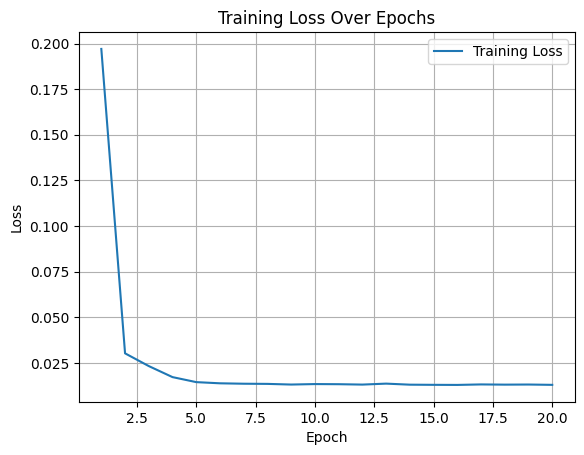

Finished Training


In [21]:
import matplotlib.pyplot as plt
from tqdm import tqdm


num_epochs = 20
optimizer = optim.Adam(model.parameters(),1e-3)
criterion = nn.MSELoss()

# Lists to store training losses
train_losses = []

model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}')
    
    for i, (inputs, targets) in progress_bar:
        inputs, targets = inputs.to(device, dtype=torch.float32), targets.to(device, dtype=torch.float32)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        progress_bar.set_postfix(loss=running_loss / (i + 1))
    
    # Calculate average training loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

# Plotting the training loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
print('Finished Training')


In [22]:
model.eval()  # Set model to evaluation mode

eval_loss = 0.0
eval_mse = 0.0
eval_mae = 0.0

# Disable gradient calculation
with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc='Evaluation'):
        inputs, targets = inputs.to(device, dtype=torch.float32), targets.to(device, dtype=torch.float32)
 
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        eval_loss += loss.item()
        
        # Calculate MSE
        mse = nn.MSELoss()(outputs, targets)
        eval_mse += mse.item()
        
        # Calculate MAE
        mae = nn.L1Loss()(outputs, targets)
        eval_mae += mae.item()

# Calculate average evaluation loss, MSE, and MAE
eval_loss /= len(test_loader)
eval_mse /= len(test_loader)
eval_mae /= len(test_loader)

print(f'Evaluation Loss: {eval_loss}')
print(f'Evaluation MSE: {eval_mse}')
print(f'Evaluation MAE: {eval_mae}')


Evaluation: 100%|██████████| 24/24 [00:00<00:00, 70.39it/s]

Evaluation Loss: 0.01524530069824929
Evaluation MSE: 0.01524530069824929
Evaluation MAE: 0.08996905696888764


I-Transformer

In [23]:
class EncoderLayer(nn.Module):
    def __init__(self, model_dim, ffn_dim, num_heads, dropout_rate=0.1):
        super(EncoderLayer, self).__init__()
        self.self_attention = MultiHeadAttention(model_dim, num_heads)
        self.ffn = FFLayer(model_dim, ffn_dim)
        self.norm1 = nn.LayerNorm(model_dim)
        self.norm2 = nn.LayerNorm(model_dim)
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        # Multi-Head Self-Attention
        residual = x
        out = self.self_attention(x, x, x)
        out = self.dropout(out)
        out = self.norm1(out + residual)

        # Feed Forward Network
        residual = out
        out = self.ffn(out)
        out = self.dropout(out)
        out = self.norm2(out + residual)

        return out


class Encoder(nn.Module):
    def __init__(self, model_dim, ffn_dim, num_heads, num_layers, dropout_rate=0.1):
        super(Encoder, self).__init__()
        self.layers = nn.ModuleList([EncoderLayer(model_dim, ffn_dim, num_heads, dropout_rate) for _ in range(num_layers)])

    def forward(self, x):
        for layer in self.layers:
            x = layer(x)
        return x


In [24]:
class MyEmbedding(nn.Module):
    def __init__(self, input_dim, embedding_dim):
        super(MyEmbedding, self).__init__()
        self.dense = nn.Linear(input_dim, embedding_dim)
        self.dropout = nn.Dropout(0.1)

    def forward(self, x):
        x = self.dropout(self.dense(x.permute(0, 2, 1)))
        return x

class MyTransformer(nn.Module):
    def __init__(self, embedding_dim=128, ffn_hidden_dim=512, num_heads=4, num_layers=2, input_len=10, pred_len=1):
        super(MyTransformer, self).__init__()
        self.input_len = input_len
        self.pred_len = pred_len
        self.embedding = MyEmbedding(self.input_len, embedding_dim)
        self.encoder = Encoder(embedding_dim, ffn_hidden_dim, num_heads, num_layers)
        self.decoder_out = nn.Linear(embedding_dim, pred_len, bias=True)

    def forward(self, x_enc):
        mean = x_enc - x_enc.mean(1, keepdim=True).detach()
        x_enc = x_enc - mean
        std = torch.sqrt(torch.var(x_enc, dim=1, keepdim=True, unbiased=False) + 1e-5)
        x_enc /= std
        NV = x_enc.shape[2]
        enc_out = self.embedding(x_enc)
        enc_out = self.encoder(enc_out)
        dec_out = self.decoder_out(enc_out).permute(0, 2, 1)[:, :, :NV]
        dec_out = dec_out * (std[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
        dec_out = dec_out + (mean[:, 0, :].unsqueeze(1).repeat(1, self.pred_len, 1))
        return dec_out[:, -self.pred_len:, :]


In [25]:
import torch
import torch.nn as nn
from math import sqrt

class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super(ScaledDotProductAttention, self).__init__()
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, q, k, v, mask=None):
        # Calculate attention scores
        scores = torch.matmul(q, k.transpose(-2, -1)) / sqrt(q.size(-1))

        # Apply mask if provided
        if mask is not None:
            mask = torch.tril(scores)
            scores = scores.masked_fill(mask == 0, float('-inf'))

        # Apply softmax to get attention weights
        weights = self.softmax(scores)

        # Weighted sum of values
        output = torch.matmul(weights, v)

        return output, weights

class MultiHeadAttention(nn.Module):
    def __init__(self, model_dim, num_heads, max_seq_len=5000):
        super(MultiHeadAttention, self).__init__()
        self.model_dim = model_dim
        self.num_heads = num_heads
        self.head_dim = model_dim // num_heads

        # Linear transformations for queries, keys, and values
        self.W_q = nn.Linear(model_dim, model_dim, bias=False)
        self.W_k = nn.Linear(model_dim, model_dim, bias=False)
        self.W_v = nn.Linear(model_dim, model_dim, bias=False)

        # Final linear transformation for output
        self.W_o = nn.Linear(model_dim, model_dim)

        # Scaled Dot-Product Attention module
        self.attention = ScaledDotProductAttention()

        # Register buffer for triangular mask
        self.register_buffer('tril_mask', torch.tril(torch.ones(max_seq_len, max_seq_len)))

    def forward(self, q, k, v, seq_len=10):
        # Linear transformations
        q = self.W_q(q).view(q.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)
        k = self.W_k(k).view(k.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)
        v = self.W_v(v).view(v.size(0), -1, self.num_heads, self.head_dim).transpose(1, 2)

        # Scaled Dot-Product Attention
        output, weights = self.attention(q, k, v, mask=self.tril_mask[:seq_len, :seq_len])

        # Concatenate heads and perform final linear transformation
        output = output.transpose(1, 2).contiguous().view(output.size(0), -1, self.model_dim)
        output = self.W_o(output)

        return output

# Example Usage:
model_dim = 64  # Model dimension
num_heads = 8   # Number of attention heads
max_seq_len = 100  # Maximum sequence length
multi_head_attention = MultiHeadAttention(model_dim, num_heads, max_seq_len)

# Assuming q, k, and v are your input tensors
q = torch.randn(1, 10, model_dim)  # Batch size x Sequence length x Model dimension
k = torch.randn(1, 10, model_dim)  # Batch size x Sequence length x Model dimension
v = torch.randn(1, 10, model_dim)  # Batch size x Sequence length x Model dimension
seq_len = 10  # Length of the sequence
output = multi_head_attention(q, k, v, seq_len)
print(output.shape)  # Output shape: [batch_size, sequence_length, model_dim]


torch.Size([1, 10, 64])


In [26]:
import torch


model  = MyTransformer().to(device)

# Generating a sample tensor(feature_size=8, model_dim=512, ffn_dim=2048, num_heads=8, num_layers=6)
input_tensor = torch.randn(64, 10, 8).to(device)  # Batch size: 64, Sequence length: 10, Input dimension: 8

# Forward pass
output = model(input_tensor)

print("Output shape:", output.shape)


Output shape: torch.Size([64, 1, 8])


Epoch 20/20: 100%|██████████| 95/95 [00:00<00:00, 119.28it/s, loss=0.00921]


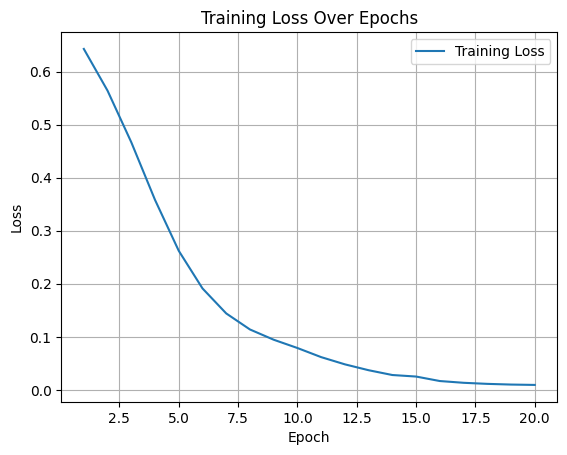

Finished Training


In [27]:
import matplotlib.pyplot as plt

# Lists to store training losses
num_epochs = 20
optimizer = optim.Adam(model.parameters(),1e-3)
criterion = nn.MSELoss()
train_losses = []

model.train()

for epoch in range(num_epochs):
    running_loss = 0.0
    
    progress_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Epoch {epoch + 1}/{num_epochs}')
    
    for i, (inputs, targets) in progress_bar:
        inputs, targets = inputs.to(device, dtype=torch.float32), targets.to(device, dtype=torch.float32)
        
        optimizer.zero_grad()
        
        outputs = model(inputs)
        
        loss = criterion(outputs, targets)
        
        loss.backward()
        
        optimizer.step()
        
        running_loss += loss.item()
        
        progress_bar.set_postfix(loss=running_loss / (i + 1))
    
    # Calculate average training loss for the epoch
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

# Plotting the training loss
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)
plt.show()
print('Finished Training')


In [28]:
model.eval()  # Set model to evaluation mode

eval_loss = 0.0
eval_mse = 0.0
eval_mae = 0.0

# Disable gradient calculation
with torch.no_grad():
    for inputs, targets in tqdm(test_loader, desc='Evaluation'):
        inputs, targets = inputs.to(device, dtype=torch.float32), targets.to(device, dtype=torch.float32)
 
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        eval_loss += loss.item()
        
        # Calculate MSE
        mse = nn.MSELoss()(outputs, targets)
        eval_mse += mse.item()
        
        # Calculate MAE
        mae = nn.L1Loss()(outputs, targets)
        eval_mae += mae.item()

# Calculate average evaluation loss, MSE, and MAE
eval_loss /= len(test_loader)
eval_mse /= len(test_loader)
eval_mae /= len(test_loader)

print(f'Evaluation Loss: {eval_loss}')
print(f'Evaluation MSE: {eval_mse}')
print(f'Evaluation MAE: {eval_mae}')


Evaluation: 100%|██████████| 24/24 [00:00<00:00, 333.26it/s]

Evaluation Loss: 0.008225435575392718
Evaluation MSE: 0.008225435575392718
Evaluation MAE: 0.06186549862225851


Which one record a better performance?

i-transformer:
Evaluation Loss: 0.00823
Evaluation MSE: 0.00823
Evaluation MAE: 0.06187

Transformer:
Evaluation Loss: 0.01525
Evaluation MSE: 0.01525
Evaluation MAE: 0.08997

The i-transformer demonstrates significantly faster performance, though the transformer converges more rapidly with fewer epochs. However, as the epoch number increases, the i-transformer surpasses the transformer, making it the better option.